# Assignment 2

In this assignment the goal is to be able to price a game based on an image. This will be done using a convolutional neural network. In what follows we first performed some ...

To Do:
- Do a round of fine-tuning of the entire model
- Add a base-line
    take the average from the training data and use it on the validation data, we want to improve this with our model


## Train, validation, test split and data pre-processing

The first step requires loading in the images and the json file that includes the price for each game and the corresponding screenshots. <br> <br>
A key aspect of this assignment was accounting for the fact that a game can have multiple images. Therefore, when the training, validation, test split was made, this was done based on the games instead of on the seperate images. For this model the decision was made to split our data 60/20/20. 


In [1]:
#Load the following packages:
import os
import json
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import tensorflow
from sklearn.model_selection import train_test_split

# Set the location of where the images are stored. Adjust if necessary
image_location = '/Users/sarahguilliams/Desktop/Advanced Analytics in a Big Data World/Assignment2/images'

# Load the json datafile
file_path = "dataset.json"

# Open the JSON file and load its contents
with open(file_path, 'r') as file:
    data = json.load(file)
data1 = pd.DataFrame(data)


# Select 10% of the games
num_selected_games = int(len(data1) * 0.1)
np.random.seed(0) #This is so that we get the same games when training the model.
selected_games = data1.sample(n=num_selected_games)
#print(selected_games) # selected 1468 games

#If we want to train on all games
#selected_games = data1

# Extract game IDs and prices
game_ids = []
prices = []
for index, game in selected_games.iterrows():
    game_ids.append(game['appid'])
    prices.append(game['price'])


# Split data into training and validation sets based on games
train1_games, test_games = train_test_split(selected_games, test_size=0.2, random_state=42)
train_games, val_games = train_test_split(train1_games, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2

Once the splitting, some pre-processing needed to occur. Here a key aspect is normalizing the images and also performing some data augmentation. In doing so we needed to account for two factors: (1) there are 125k+ images, which makes it too large to import all at once, and (2) the images are all contained in one folder. <br>

In [2]:
# Create a list of dictionaries for DataFrame
train_data = []
for index, game in train_games.iterrows():
    for screenshot in game['screenshots']:
        train_data.append({'screenshot': screenshot, 'price': game['price']})

# Create DataFrame
train_label_df = pd.DataFrame(train_data)

# Display the DataFrame
print(train_label_df)

# Do the same for the validation set
val_data = []
for index, game in val_games.iterrows():
    for screenshot in game['screenshots']:
        val_data.append({'screenshot': screenshot, 'price': game['price']})

# Create DataFrame
val_label_df = pd.DataFrame(val_data)

# Display the DataFrame
print(val_label_df)


# Do the same for the test set
# Create a list of dictionaries for DataFrame
test_data = []
for index, game in test_games.iterrows():
    for screenshot in game['screenshots']:
        test_data.append({'screenshot': screenshot, 'price': game['price']})

# Create DataFrame
test_label_df = pd.DataFrame(test_data)

# Display the DataFrame
print(test_label_df)

                                             screenshot  price
0     2613510_ss_071deac8c99a647720c55cc4977d4177d1d...    499
1     2613510_ss_94d3c698db5d4bedec07dd0cc2861e3652c...    499
2     2613510_ss_acc33137c42484a0557435d6238be2d7bdc...    499
3     2645170_ss_45025f5c1b15b6eb928799a82b05490c454...     99
4     2645170_ss_abbe69878cb6a8d2c7570b15305affeb375...     99
...                                                 ...    ...
7816  2240920_ss_38c4122975acd5334f4af4cf132ea7dcfbf...   1950
7817  2240920_ss_4a641bb1ceb2221b4636b5f7b0ddb9f203f...   1950
7818  2240920_ss_58e796b5e3f5bbb69d46bc3373d14c7f75d...   1950
7819  2240920_ss_6ffddde971aa99a15c090458d5e00ff5b28...   1950
7820  2240920_ss_e89887581aa429c2f2250b48cb3472f3240...   1950

[7821 rows x 2 columns]
                                             screenshot  price
0     1769060_ss_05f99919f16923296837f8793e4088168a3...   1479
1     1769060_ss_0829d256a914eb8af55f0c8a03c25668415...   1479
2     1769060_ss_2fe33d28ab9a5

With Keras 2.2.4 you can use flow_from_dataframe which solves what you want to do, allowing you to flow images from a directory for regression problems. You should store all your images in a folder and load a dataframe containing in one column the image IDs and in the other column the regression score (labels) and set class_mode='other' in flow_from_dataframe.

Here you can find an example where the images are in image_dir, the dataframe with the image IDs and the regression scores is loaded with pandas from the "train file"

Potentially add , horizontal_flip = True,
                                   fill_mode = "nearest", zoom_range = 0.2,
                                   width_shift_range = 0.2, height_shift_range=0.2,
                                   rotation_range=30) 
to image generator.

Currently, the images have a size of 1920 × 1080, reduction to 25% of this size to 

There are some factors that need to be taken into consideration here
Firstly, there are some games that have a screenshot name in the json file, but that are not present in the folder of images
Secondly, there are some images that are corrupted, and that therefore need to be removed from the analysis as they otherwise result in a model that cannot adequately be fit.<br>

ex : 2798210_ss_04edddb8703d37f8c36c2e249dee191f22efec5f.1920x1080.jpg is in the json file but not in the images

Additionally, there are 3 corrupted files. <br>
2445340_ss_fdbf4004c0087b96c3a8ebb1152179b3563d7091.1920x1080.jpg <br>
1029210_ss_7096afc94036153001b266a75253fb6abdd03c54.1920x1080.jpg <br>
1029210_ss_ddf975e414f08a0bb419818d2cd94be4ebff6db9.1920x1080.jpg <br>
These are deleted from the images folder

In [3]:
train_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, 
                                                                        rotation_range=45, horizontal_flip=True, vertical_flip=True)


train_generator = train_datagen.flow_from_dataframe(dataframe=train_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=(224, 224), shuffle=True,
                                              batch_size=64)

val_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 
val_generator = val_datagen.flow_from_dataframe(dataframe=val_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=(224, 224), shuffle=True,
                                              batch_size=64)

# for the test set
test_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 
# here we don't perform any transormations

test_generator = test_datagen.flow_from_dataframe(dataframe=test_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=(224, 224),
                                              batch_size=64)


Found 7420 validated image filenames.
Found 2311 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 401 invalid image filename(s) in x_col="screenshot". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 167 invalid image filename(s) in x_col="screenshot". These filename(s) will be ignored.
  warnings.warn(


Found 2402 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 184 invalid image filename(s) in x_col="screenshot". These filename(s) will be ignored.
  warnings.warn(


Using transfer learning (using a pre-trained model)
https://keras.io/guides/transfer_learning/
Remove the top last layers so these can be trained on our data.
https://www.tensorflow.org/guide/keras/transfer_learning
https://www.tensorflow.org/tutorials/images/transfer_learning#create_the_base_model_from_the_pre-trained_convnets

In [4]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential


inputs= layers.Input(shape=(224, 224, 3))
base_model = EfficientNetB0(
    include_top=False, #Do not use the imagenet at the top
    weights="imagenet",
    input_tensor= inputs,
    pooling=None,
)
#base_model.summary()

# Freeze the base model
base_model.trainable = False

# Add a layer on top
x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
x = layers.BatchNormalization()(x)
top_dropout_rate = 0.4
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(1, name="prediction")(x)


model = keras.Model(inputs, outputs)



In [5]:
# Train the model
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=keras.losses.MeanAbsolutePercentageError(), metrics=[keras.metrics.MeanAbsolutePercentageError()])
print("Model is compiled")



Model is compiled


In [6]:
# fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=2,
    validation_data=val_generator,
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


116/116 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - loss: 90455048.0000 - mean_absolute_percentage_error: 90451576.0000 - val_loss: 71743408.0000 - val_mean_absolute_percentage_error: 70357480.0000


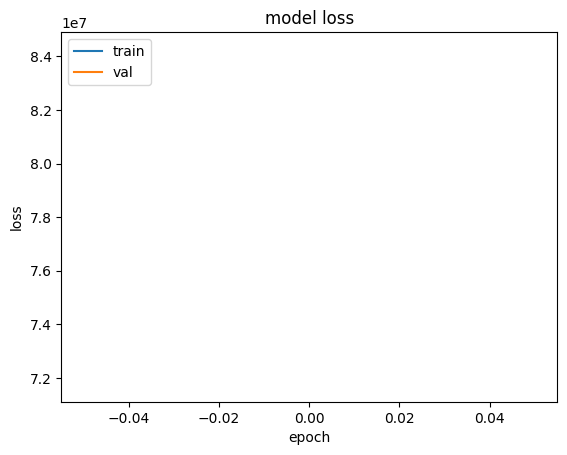

In [7]:
# Plotting the error
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Give the predicted price for a game


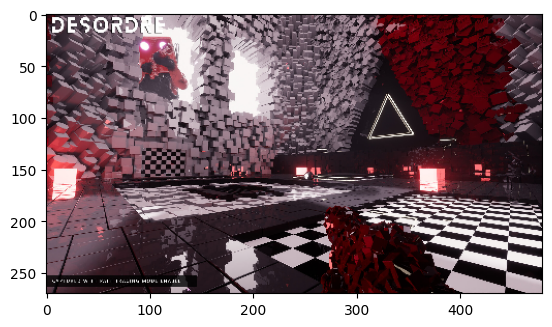

NameError: name 'model' is not defined

In [9]:
# Define the image location
filename = '2097490_ss_8cbd04bf288e050789f7da39345ecdd113cdabaa.1920x1080.jpg'

# Construct the full path to the image
image_path = os.path.join(image_location, filename)

# Load and display the image
img = keras.utils.load_img(image_path, target_size=(270, 480))
plt.imshow(img)
plt.show()

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions)



_________________________________________________________________________________________________________________________